In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [86]:
data = pd.read_csv('air_quality.csv', sep=';', decimal=',', header=0)
data = data.drop(columns = ['Unnamed: 15', 'Unnamed: 16']).dropna().replace(-200, np.nan)
print(data.isna().sum())
data = data.drop(columns = ['Date', 'Time', 'NMHC(GT)']) # 'NMHC(GT)' has 8443 missing values which is too much considering total of 9k instances

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


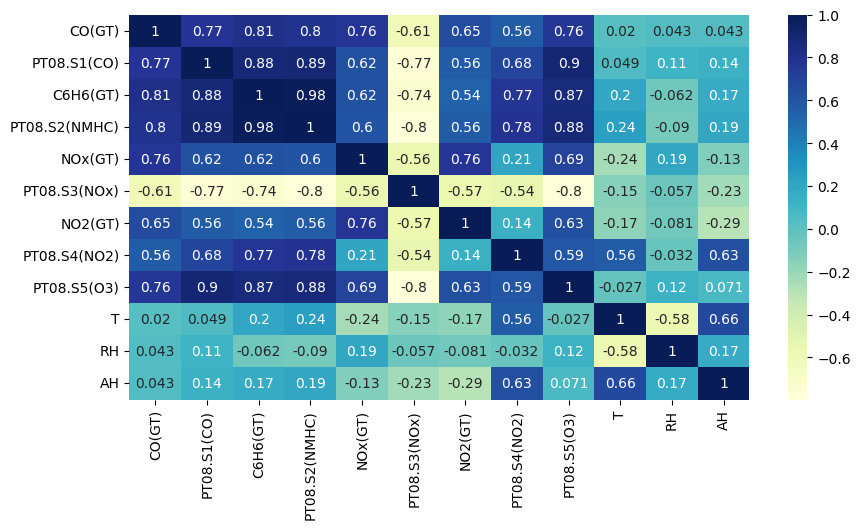

In [87]:
for i, col in enumerate(data.columns):
  data[col] = data[col].fillna(data[col].mean()) # Filling missing values with mean of the column for simplicity and to avoid data loss due to dropping rows with missing values 
data.isna().sum()

plt.figure(figsize=(10,5))
sns.heatmap(data.corr(),cmap='YlGnBu',annot=True) # Correlation matrix
plt.show()

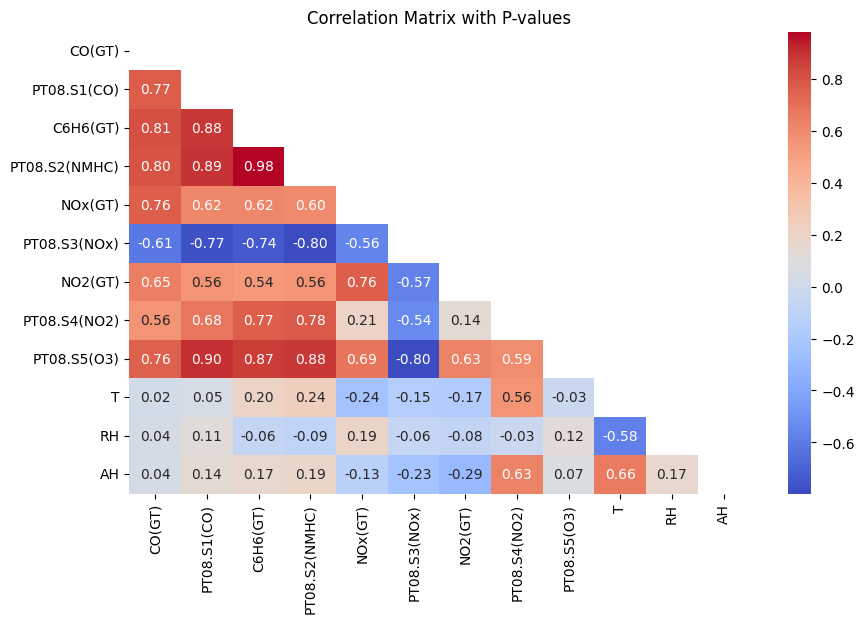

In [88]:
import scipy.stats as stats

def plot_correlation_with_p_values(df): # Function to plot correlation matrix with p-values
    corr_matrix = df.corr()
    p_vals = pd.DataFrame(np.ones(corr_matrix.shape), columns=df.columns, index=df.columns)

    for row in df.columns:
        for col in df.columns:
            if row != col:
                _, p = stats.pearsonr(df[row], df[col])
                p_vals.loc[row, col] = p
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=np.triu(corr_matrix))
    plt.title('Correlation Matrix with P-values')
    plt.show()
    
    return p_vals

p_vals = plot_correlation_with_p_values(data)


In [89]:
X = data.drop(columns = ['CO(GT)']) # Features
y = data['CO(GT)'] # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [90]:
from sklearn.feature_selection import RFE

def select_features_with_rfe(model, X_train, y_train): # Function to select features using Recursive Feature Elimination
    selector = RFE(model, n_features_to_select=5, step=1) # Selecting 5 features
    selector = selector.fit(X_train, y_train)
    
    selected_features = X.columns[selector.support_]
    print(f"Selected Features: {selected_features}")
    return selected_features

# Example: Using RFE with RandomForest
selected_features = select_features_with_rfe(RandomForestRegressor(), X_train_scaled, y_train)


Selected Features: Index(['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'T'], dtype='object')


In [118]:
# Even though 'T' does not have a high correlation with 'CO(GT)', it is selected as a feature by RFE, it may be due to non-linear relationship between 'T' and 'CO(GT)'

In [91]:
# X = data.drop(columns=['CO(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH', 'AH'])
# y = data['CO(GT)']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [92]:
data.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.152750,1099.833166,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.316068,212.791672,7.302650,261.560236,193.426632,251.743954,43.920954,339.367559,390.612324,8.657639,16.974801,0.395835
min,0.100000,647.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.200000,941.000000,4.600000,743.000000,112.000000,666.000000,86.000000,1242.000000,742.000000,12.000000,36.600000,0.746100
50%,2.152750,1075.000000,8.600000,923.000000,229.000000,818.000000,113.091251,1456.264598,983.000000,18.300000,49.234201,1.015400
75%,2.600000,1221.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [93]:
def evaluate_model(model, X_train, y_train, X_test, y_test): # Function to evaluate model
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    return mse_train, r2_train, mse_test, r2_test

In [120]:
dummy_regressor = DummyRegressor(strategy="mean") # Dummy Regressor with mean strategy as baseline model for comparison
dummy_regressor.fit(X_train_scaled, y_train)
y_pred_dummy = dummy_regressor.predict(X_test_scaled) 

mse_dummy = mean_squared_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

print(f"Dummy Regressor (Mean) - MSE: {mse_dummy}, R2: {r2_dummy}")


Dummy Regressor (Mean) - MSE: 1.8566755913171629, R2: -6.037879502840404e-05


In [121]:
from sklearn.tree import DecisionTreeRegressor

# tree_regressor = DecisionTreeRegressor(random_state=42)
# tree_regressor.fit(X_train_scaled, y_train)
# y_pred_tree = tree_regressor.predict(X_test_scaled)

# mse_tree = mean_squared_error(y_test, y_pred_tree)
# r2_tree = r2_score(y_test, y_pred_tree)

# print(f"Decision Tree - MSE: {mse_tree}, R2: {r2_tree}")


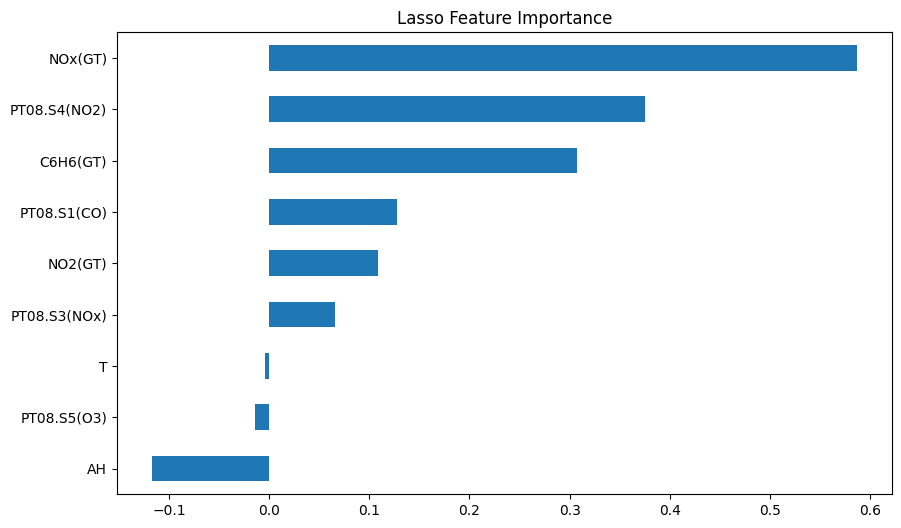

In [96]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

# Plotting the coefficients
lasso_coeff = pd.Series(lasso.coef_, index=X.columns)
plt.figure(figsize=(10, 6))
lasso_coeff[lasso_coeff != 0].sort_values().plot(kind='barh')
plt.title('Lasso Feature Importance')
plt.show() # Lasso feature importance plot


In [97]:
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Decision Tree": (DecisionTreeRegressor(), {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['squared_error', 'friedman_mse']}),
    "Ridge": (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
    "Lasso": (Lasso(), {'alpha': [0.01, 0.1, 1.0]}),
    "Random Forest": (RandomForestRegressor(), {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}),
    "Gradient Boosting": (GradientBoostingRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01]}),
    "Multi-Layer Perceptron": (MLPRegressor(), {'hidden_layer_sizes': [(40, 40, 40)], 'activation': ['relu'], 'alpha': [0.01], 'learning_rate': ['constant'], 'solver': ['adam']}),
    "K-Nearest Neighbors": (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']})
}

In [98]:
results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    
    mse_train, r2_train, mse_test, r2_test = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)
    
    overfitting_score = mse_train - mse_test  # Positive value indicates overfitting
    
    results[model_name] = {
        'mse_train': mse_train, 
        'r2_train': r2_train,
        'mse_test': mse_test,
        'r2_test': r2_test,
        'overfitting_score': overfitting_score,
        'best_params': grid_search.best_params_,
        'best_model': best_model
    }

    print(f"{model_name} - Train MSE: {mse_train}, Test MSE: {mse_test}, Overfitting Score: {overfitting_score}")


Linear Regression - Train MSE: 0.3536998614025249, Test MSE: 0.3462349740124412, Overfitting Score: 0.007464887390083719
Decision Tree - Train MSE: 0.20608338959814407, Test MSE: 0.3113585642135556, Overfitting Score: -0.10527517461541155
Ridge - Train MSE: 0.3537416166659055, Test MSE: 0.3468072220356054, Overfitting Score: 0.0069343946303001
Lasso - Train MSE: 0.3601104902500134, Test MSE: 0.355998880358068, Overfitting Score: 0.0041116098919454225
Random Forest - Train MSE: 0.035856473623538554, Test MSE: 0.23197146590860035, Overfitting Score: -0.1961149922850618
Gradient Boosting - Train MSE: 0.17716594051647344, Test MSE: 0.2685849391067071, Overfitting Score: -0.09141899859023367
Multi-Layer Perceptron - Train MSE: 0.17299514352004788, Test MSE: 0.2298916175491092, Overfitting Score: -0.05689647402906131
K-Nearest Neighbors - Train MSE: 0.002129096416276423, Test MSE: 0.24345962160433451, Overfitting Score: -0.2413305251880581


In [99]:
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_poly, y_train)
y_pred_poly = linear_regressor.predict(X_test_poly)

mse_train, r2_train, mse_test, r2_test = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Polynomial Regression - Train MSE: {mse_train}, Test MSE: {mse_test}")

overfitting_score = mse_train - mse_test

results['Linear Regression with Polynomial Features'] = {
        'mse_train': mse_train, 
        'r2_train': r2_train,
        'mse_test': mse_test,
        'r2_test': r2_test,
        'overfitting_score': overfitting_score,
        'best_params': None,
        'best_model': linear_regressor
    }

Polynomial Regression - Train MSE: 0.002129096416276423, Test MSE: 0.24345962160433451


In [122]:
def detect_overfitting(mse_train, mse_test, tolerance=0.1):
    diff = abs(mse_train - mse_test)
    if mse_train < mse_test and diff > tolerance:
        return f"Underfitting (Difference: {diff})"
    elif mse_test < mse_train:
        return f"Overfitting (Difference: {diff})"
    else:
        return f"Balanced (Difference: {diff})"

for model_name, model_info in results.items():
    overfitting_status = detect_overfitting(model_info['mse_train'], model_info['mse_test'])
    print(f"{model_name}: {overfitting_status}")

Linear Regression: Overfitting (Difference: 0.007464887390083719)
Decision Tree: Underfitting (Difference: 0.10527517461541155)
Ridge: Overfitting (Difference: 0.0069343946303001)
Lasso: Overfitting (Difference: 0.0041116098919454225)
Random Forest: Underfitting (Difference: 0.1961149922850618)
Gradient Boosting: Balanced (Difference: 0.09141899859023367)
Multi-Layer Perceptron: Balanced (Difference: 0.05689647402906131)
K-Nearest Neighbors: Underfitting (Difference: 0.2413305251880581)
Linear Regression with Polynomial Features: Underfitting (Difference: 0.2413305251880581)


In [101]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by='mse_test', ascending=True, inplace=True)
print(results_df)

                                           mse_train  r2_train  mse_test  \
Multi-Layer Perceptron                      0.172995  0.898276  0.229892   
Random Forest                               0.035856  0.978916  0.231971   
K-Nearest Neighbors                         0.002129  0.998748   0.24346   
Linear Regression with Polynomial Features  0.002129  0.998748   0.24346   
Gradient Boosting                           0.177166  0.895824  0.268585   
Decision Tree                               0.206083   0.87882  0.311359   
Linear Regression                             0.3537  0.792019  0.346235   
Ridge                                       0.353742  0.791995  0.346807   
Lasso                                        0.36011   0.78825  0.355999   

                                             r2_test overfitting_score  \
Multi-Layer Perceptron                      0.876174         -0.056896   
Random Forest                               0.875053         -0.196115   
K-Nearest Neighbo

In [107]:
def plot_cv_results(model_name, grid_search):
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    plt.figure(figsize=(8, 6))
    plt.plot(means, label='Mean CV Score')
    plt.fill_between(range(len(means)), means - stds, means + stds, alpha=0.1, label='Std Dev')
    plt.title(f'Cross-Validation Performance for {model_name}')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Test Score')
    plt.legend()
    plt.show()

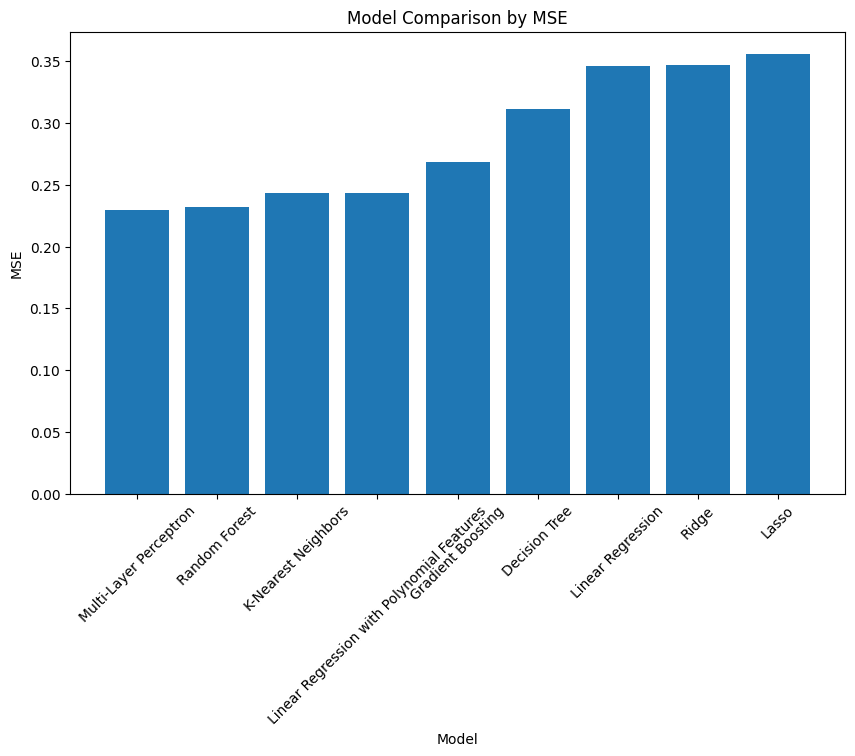

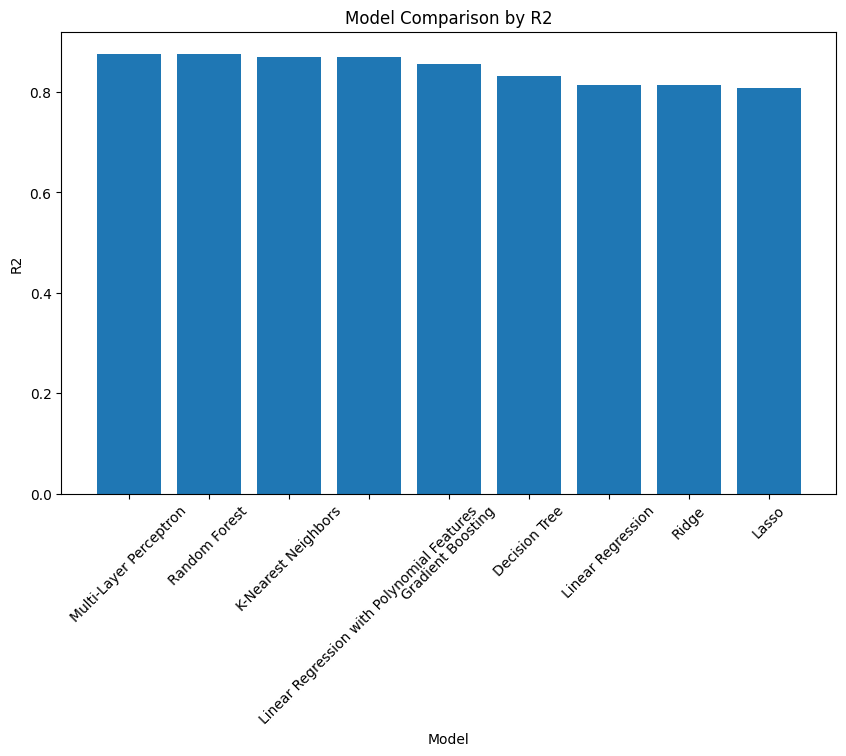

In [108]:
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['mse_test'])
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model Comparison by MSE')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['r2_test'])
plt.xlabel('Model')
plt.ylabel('R2')
plt.title('Model Comparison by R2')
plt.xticks(rotation=45)
plt.show()

Here, MLP and Random Forest models have the lowest MSE and highest R2 scores. However, MLP model has been selected as the best model due to its lower overfitting score compared to Random Forest model. It is important to consider overfitting while selecting the best model and MLP is Balanced in terms of overfitting.

KNN and Gradient Boosting are also good models with low overfitting scores. However, KNN has a higher MSE compared to MLP and Gradient Boosting has a higher overfitting score compared to MLP. Overall, for small datasets, MLP is a good choice due to its flexibility and ability to capture non-linear relationships. Speaking of KNN, it is a good choice for small datasets as well, but it is computationally expensive compared to MLP

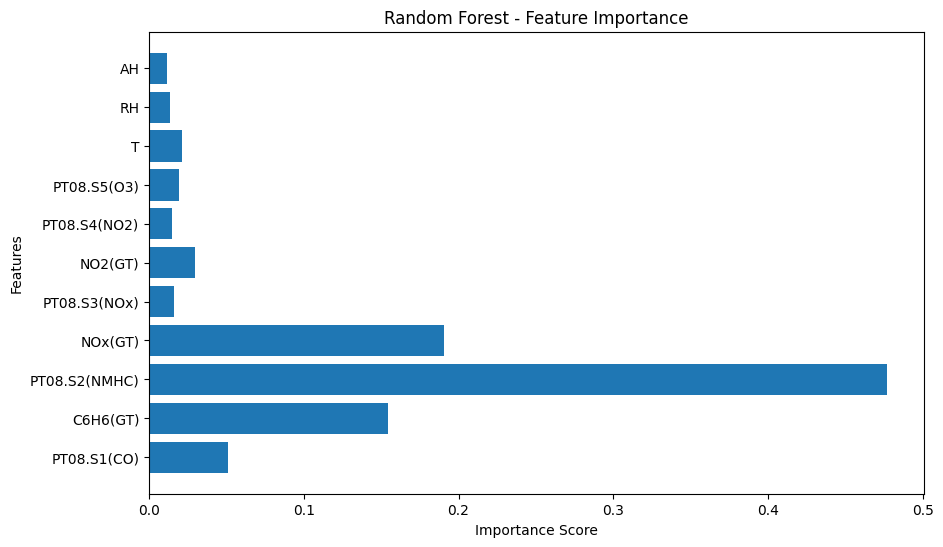

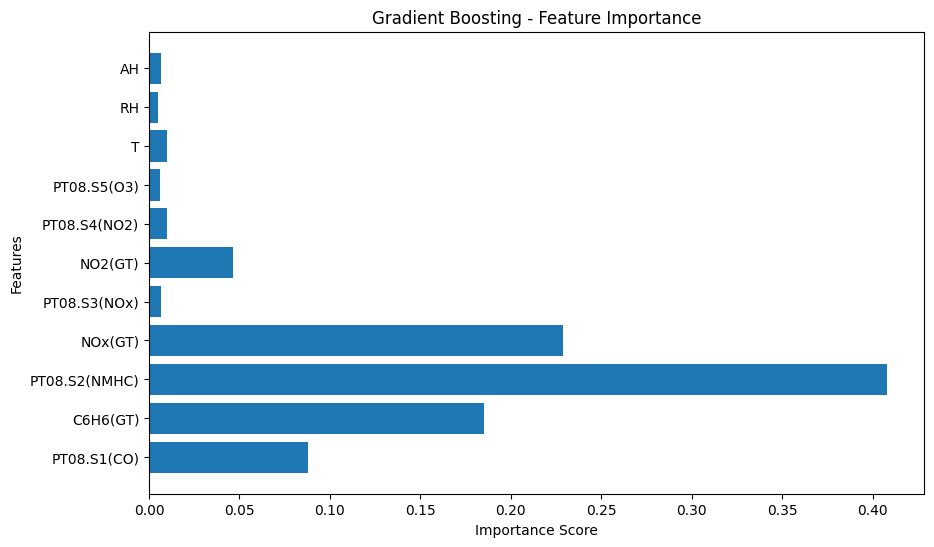

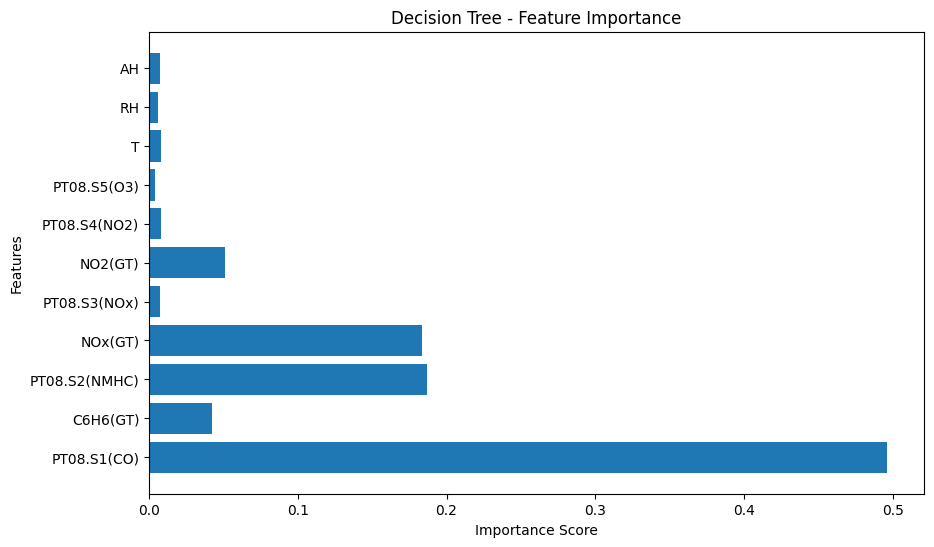

In [111]:
def plot_feature_importance(model, model_name):
    importance = model.feature_importances_
    features = X.columns
    plt.figure(figsize=(10, 6))
    plt.barh(features, importance)
    plt.title(f'{model_name} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

plot_feature_importance(results['Random Forest']['best_model'], 'Random Forest')
plot_feature_importance(results['Gradient Boosting']['best_model'], 'Gradient Boosting')
plot_feature_importance(results['Decision Tree']['best_model'], 'Decision Tree')

We can see that last 4 features are the most important features for all 3 models. The importance of the features are consistent across the models. This indicates that these features are the most important features for predicting 'CO(GT)'. Even though C6H6's relation is small for Decision Tree, it is still one of the most important features for Random Forest and Gradient Boosting models.

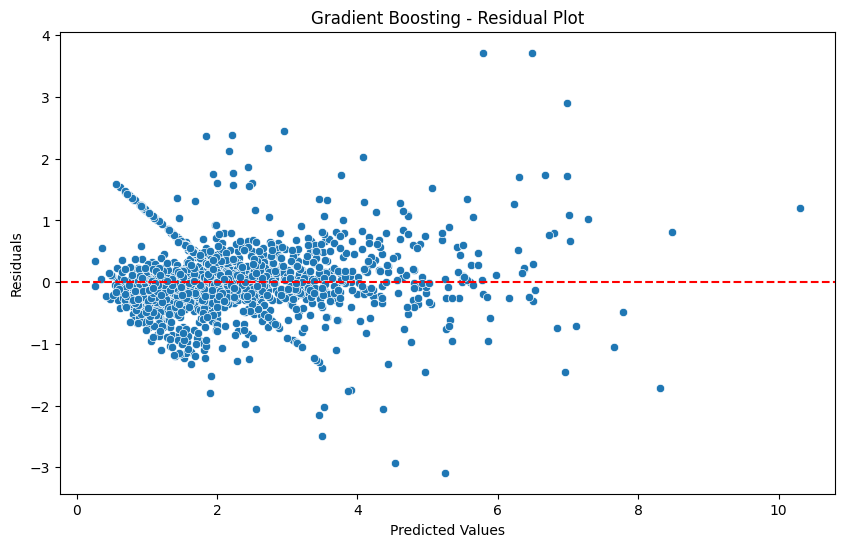

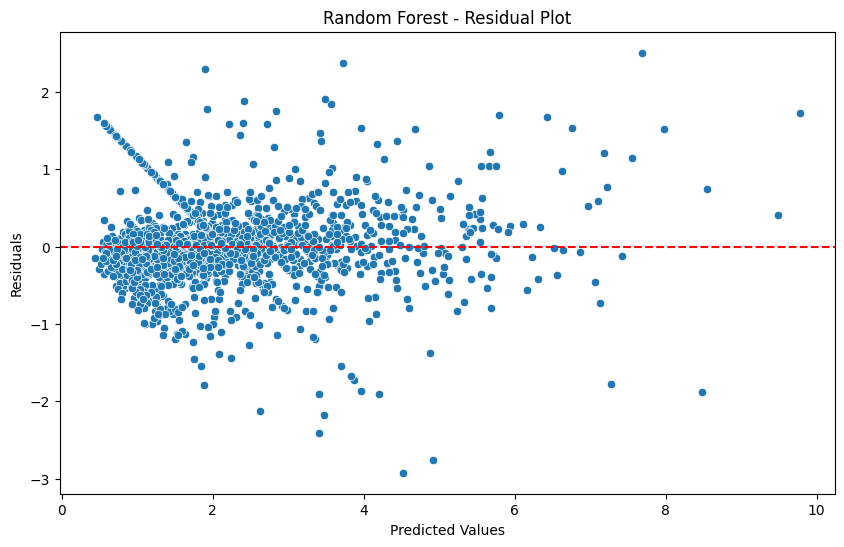

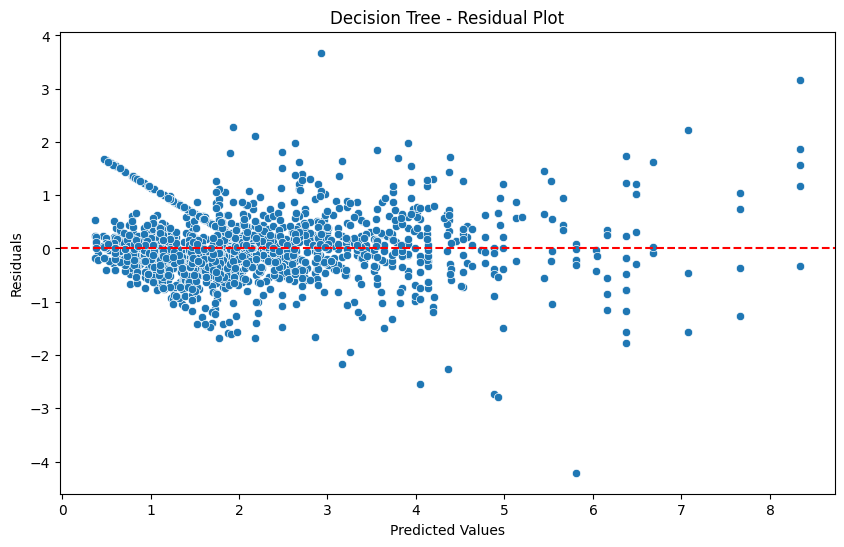

In [113]:
def plot_residuals(model, X_test_scaled, y_test, model_name):
    y_pred = model.predict(X_test_scaled)
    residuals = y_test - y_pred

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residual Plot')
    plt.show()

plot_residuals(results['Gradient Boosting']['best_model'], X_test_scaled, y_test, 'Gradient Boosting')
plot_residuals(results['Random Forest']['best_model'], X_test_scaled, y_test, 'Random Forest')
plot_residuals(results['Decision Tree']['best_model'], X_test_scaled, y_test, 'Decision Tree')


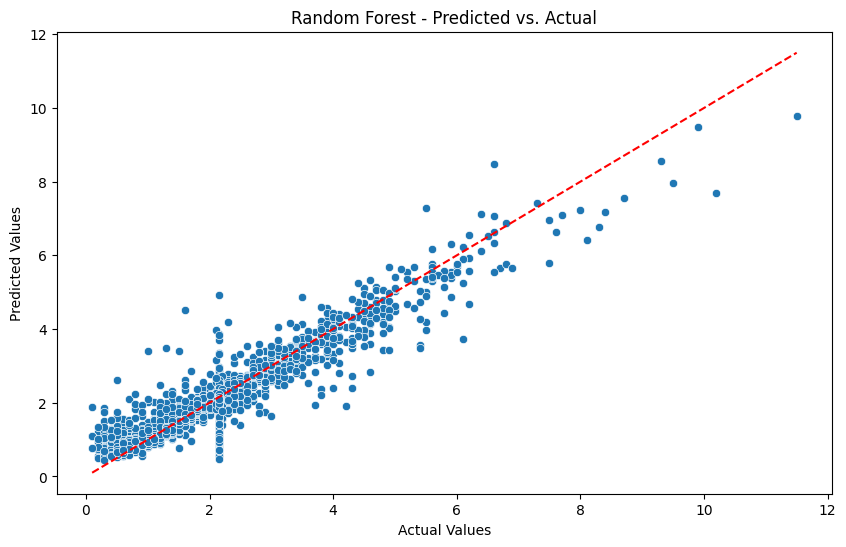

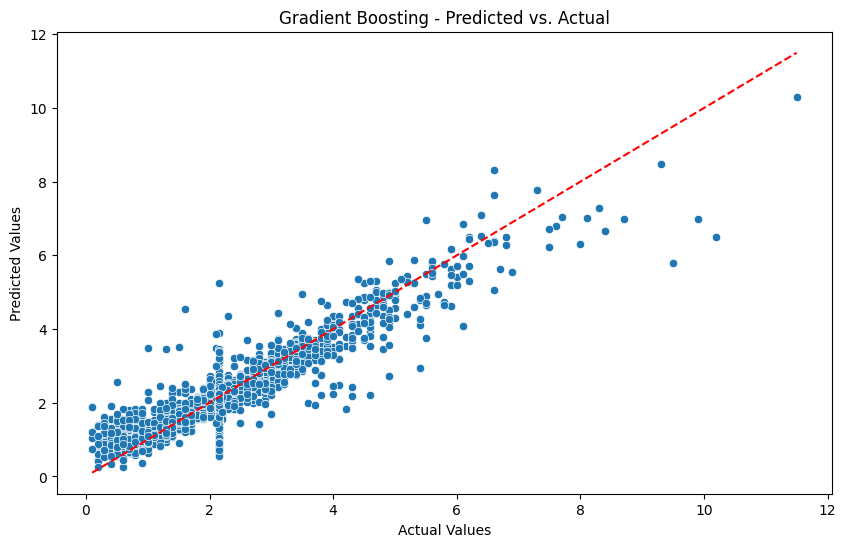

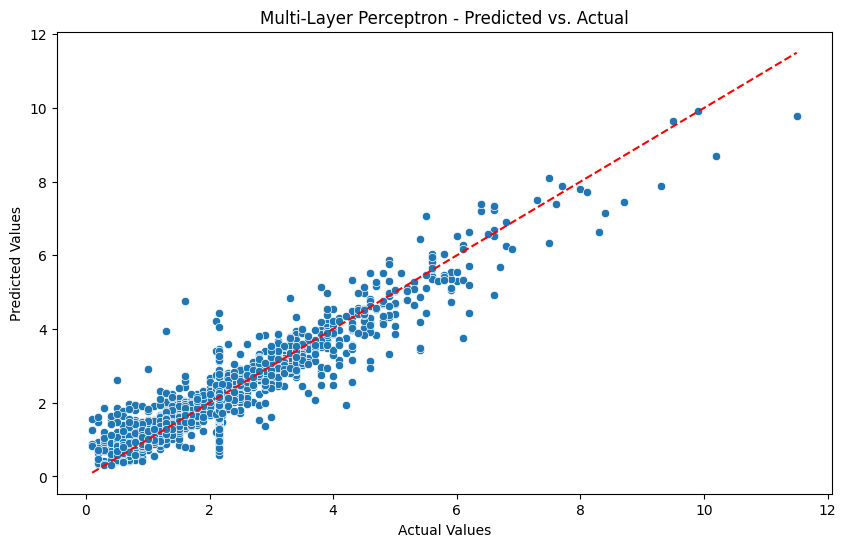

In [115]:
def plot_predicted_vs_actual(model, X_test_scaled, y_test, model_name):
    y_pred = model.predict(X_test_scaled)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Predicted vs. Actual')
    plt.show()

plot_predicted_vs_actual(results['Random Forest']['best_model'], X_test_scaled, y_test, 'Random Forest')
plot_predicted_vs_actual(results['Gradient Boosting']['best_model'], X_test_scaled, y_test, 'Gradient Boosting')
plot_predicted_vs_actual(results['Multi-Layer Perceptron']['best_model'], X_test_scaled, y_test, 'Multi-Layer Perceptron')

Red dashed line represents perfect predictions (y_test = y_pred), points close to this line indicate good predictions by the model and vice versa

The closer the points are to the red dashed line, the better the model is at predicting the target variable

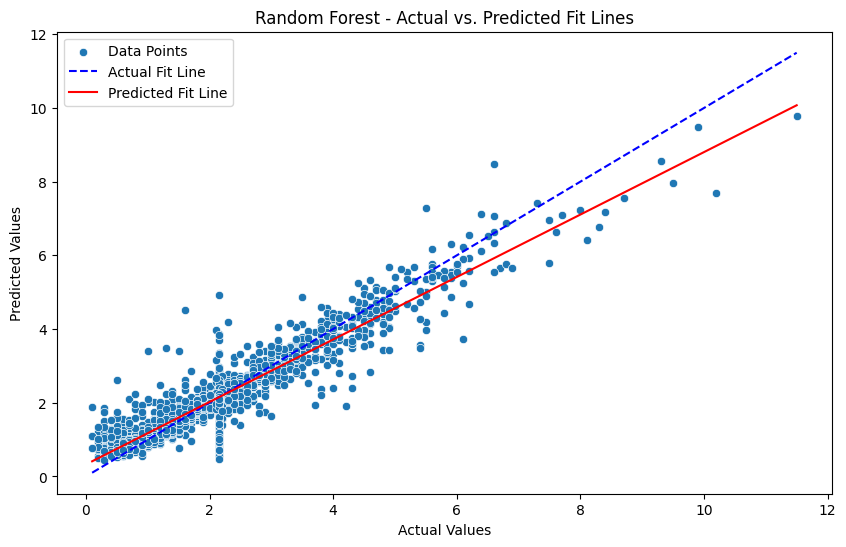

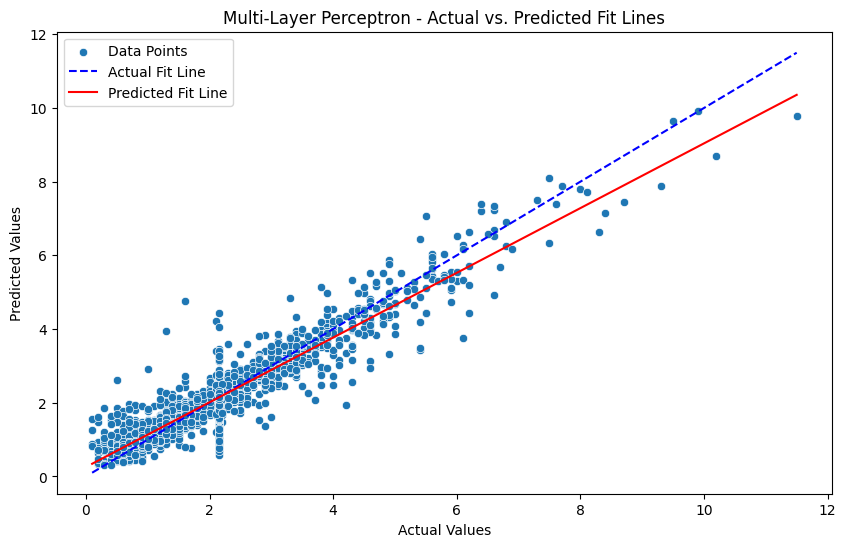

In [125]:
def plot_fit_lines(model, X_test_scaled, y_test, model_name):
    y_test_np = y_test.values.reshape(-1, 1)

    y_pred = model.predict(X_test_scaled)

    actual_line = LinearRegression().fit(y_test_np, y_test_np)
    predicted_line = LinearRegression().fit(y_test_np, y_pred.reshape(-1, 1))

    x_range = np.linspace(y_test.min(), y_test.max(), 100).reshape(-1, 1)
    actual_fit_line = actual_line.predict(x_range)
    predicted_fit_line = predicted_line.predict(x_range)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, label='Data Points')

    plt.plot(x_range, actual_fit_line, color='blue', label='Actual Fit Line', linestyle='--')
    plt.plot(x_range, predicted_fit_line, color='red', label='Predicted Fit Line', linestyle='-')

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Actual vs. Predicted Fit Lines')
    plt.legend()
    plt.show()

plot_fit_lines(results['Random Forest']['best_model'], X_test_scaled, y_test, 'Random Forest')
plot_fit_lines(results['Multi-Layer Perceptron']['best_model'], X_test_scaled, y_test, 'Multi-Layer Perceptron')

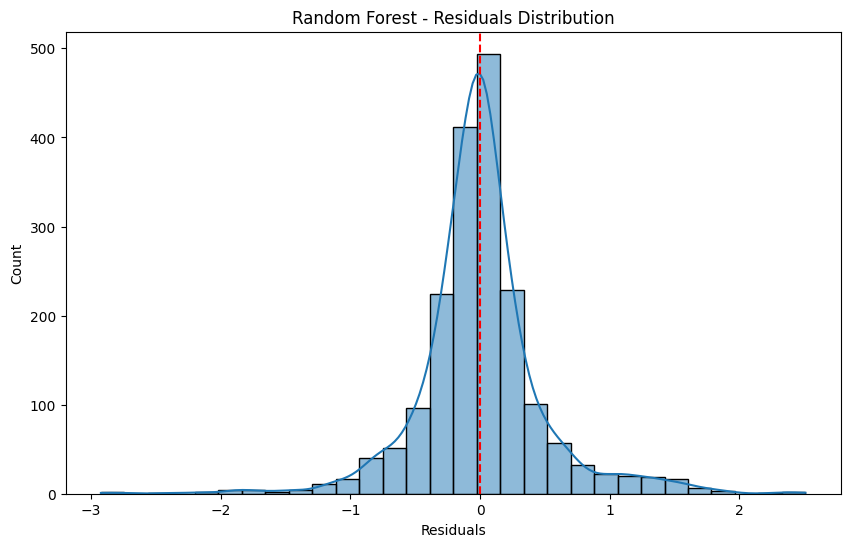

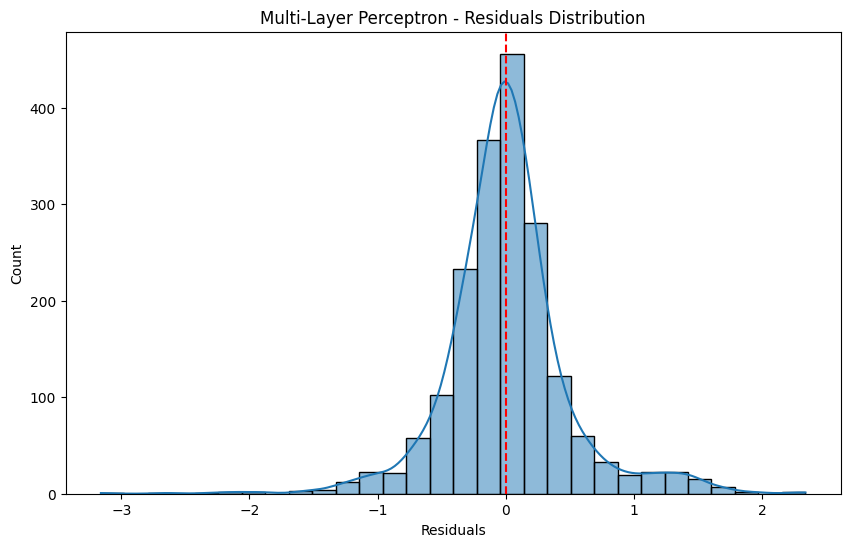

In [117]:
def plot_residuals_distribution(model, X_test_scaled, y_test, model_name):
    y_pred = model.predict(X_test_scaled)
    residuals = y_test - y_pred
    
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.axvline(0, color='r', linestyle='--')
    plt.xlabel('Residuals')
    plt.title(f'{model_name} - Residuals Distribution')
    plt.show()

plot_residuals_distribution(results['Random Forest']['best_model'], X_test_scaled, y_test, 'Random Forest')
plot_residuals_distribution(results['Multi-Layer Perceptron']['best_model'], X_test_scaled, y_test, 'Multi-Layer Perceptron')

In [ ]:
# Residuals Distribution for Random Forest and MLP models shows that the residuals are normally distributed around 0, which is a good sign for the model's performance. Other models had some skewness in the residuals distribution.